In [34]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import datetime as dt

In [35]:
from fmiopendata.wfs import download_stored_query

In [36]:
# Retrieve the latest 0.1 hour of data from a bounding box
end_time = dt.datetime(2022, 3, 15, 11, 17)
start_time = end_time - dt.timedelta(hours=0.1)
# Convert times to properly formatted strings
start_time = start_time.isoformat(timespec="seconds") + "Z"
end_time = end_time.isoformat(timespec="seconds") + "Z"

obs = download_stored_query("fmi::observations::weather::multipointcoverage",
                            args=["bbox=18,55,35,75",
                                  "starttime=" + start_time,
                                  "endtime=" + end_time])

In [37]:
# The observation times are the primary key
print(sorted(obs.data.keys()))
latest_time_step = max(obs.data.keys())

[datetime.datetime(2022, 3, 15, 11, 11), datetime.datetime(2022, 3, 15, 11, 12), datetime.datetime(2022, 3, 15, 11, 13), datetime.datetime(2022, 3, 15, 11, 14), datetime.datetime(2022, 3, 15, 11, 15), datetime.datetime(2022, 3, 15, 11, 16), datetime.datetime(2022, 3, 15, 11, 17)]


In [38]:
# measurements associated with a station
obs.data[dt.datetime(2022, 3, 15, 11, 17)]['Jomala Maarianhamina lentoasema'] 

for dmy in obs.data.keys(): 
    
       print(dmy,obs.data[dmy]['Jomala Maarianhamina lentoasema']['Air temperature'])


2022-03-15 11:11:00 {'value': 5.8, 'units': 'degC'}
2022-03-15 11:12:00 {'value': 6.1, 'units': 'degC'}
2022-03-15 11:13:00 {'value': 6.2, 'units': 'degC'}
2022-03-15 11:14:00 {'value': 6.0, 'units': 'degC'}
2022-03-15 11:15:00 {'value': 5.9, 'units': 'degC'}
2022-03-15 11:16:00 {'value': 5.9, 'units': 'degC'}
2022-03-15 11:17:00 {'value': 5.9, 'units': 'degC'}


In [39]:
import pandas as pd 
import geopy.distance

num_nodes = len(obs.location_metadata.keys())
print("Number of nodes:", num_nodes)


coords = obs.location_metadata  ## latitude and longitude of each station

df_coords = pd.DataFrame.from_dict(coords, orient='index')

Number of nodes: 40


In [40]:
def get_dist(nodeA,nodeB):
    """calculate the distance between two different stations"""
    coords_1 = (coords[list(coords.keys())[nodeA]]['latitude'], coords[list(coords.keys())[nodeA]]['longitude'])
    coords_2 = (coords[list(coords.keys())[nodeB]]['latitude'], coords[list(coords.keys())[nodeB]]['longitude'])
    return geopy.distance.geodesic(coords_1, coords_2).miles

In [41]:
def add_edges(graph,total_neigh=4):
    num_nodes = graph.number_of_nodes()
    for i in range(num_nodes):
            node_dists = []
            '''
            a list containing the distance between node i and other nodes of the graph
            '''
            for j in range(num_nodes):
                if j == i:
                    continue
                node_dists.append(get_dist(i, j))

            # sort node_dists in order to pick the nearest nodes to the node i 
            node_dists.sort(reverse=True)
    #         print(node_dists)

            node_cnt = 0
            for j in range(num_nodes):

                if node_cnt >= total_neigh:
                    break

                if j == i:
                    continue

                # calculate the distance between node i and j of the graph
                dist = get_dist(i, j)
                if dist == 0 or dist < node_dists[total_neigh]:
                    continue
                node_cnt += 1
                graph.add_edge(i, j)
    return graph

In [42]:
graph = nx.Graph()
graph.add_nodes_from(range(0,num_nodes))
total_neigh=1

for i in range(num_nodes):
            node_dists = []
            '''
            a list containing the distance between node i and other nodes of the graph
            '''
            for j in range(num_nodes):
                node_dists.append(get_dist(i, j))

            # sort node_dists in order to pick the nearest nodes to the node i 
            node_dists.sort(reverse=False)
    #         print(node_dists)
           # print(node_dists[0])
print(node_dists)

[0.0, 54.296702814814, 55.31119158576606, 59.29489252333333, 69.46264756401246, 70.07802862941016, 79.64454536513368, 84.57797246615056, 85.7089566567622, 92.82456557032756, 103.39469678523002, 109.5882525123819, 115.7029999890242, 119.83055778587004, 120.80488488896114, 122.55816967578106, 122.74556291755128, 132.905204067216, 157.18459084002532, 178.8550479424536, 180.34688328886912, 183.9328638467944, 191.34037797054995, 199.3083863410278, 232.30535007176903, 236.67251296070762, 246.27345495015464, 256.99557733083265, 268.81000755165, 268.98541533640895, 269.06205615794903, 295.2511430180801, 304.5436201759171, 316.5923597491272, 340.77337627311334, 340.87098015302985, 393.78530249670143, 421.6654491450464, 475.1963821147376, 479.8554947046169]


40
0


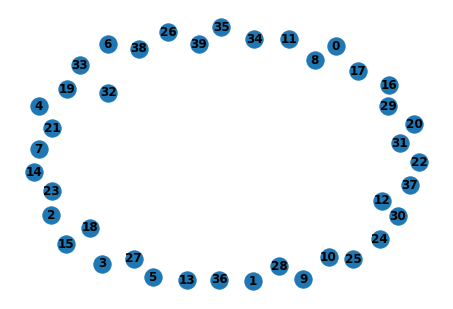

In [43]:
print(graph.number_of_nodes())
print(graph.number_of_edges())

for dmy in graph.nodes: 
    graph.nodes[dmy]['name'] = df_coords.iloc[dmy].name
    
nx.draw(graph, with_labels=True, font_weight='bold')

In [44]:
def get_B_and_weight_vec(all_models_train_images, neigh_cnt=3):
    '''
    :param trained_models_train_images: A list containing the images used for training each model
    :param neigh_cnt: number of the neighbors for each node of the empirical graph G
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    '''
    
    N = len(all_models_train_images)
    E = int(N * (N - 1) / 2)

    weight_vec = np.zeros(E)
    '''
    the weight vector of the edges of the empirical graph G
    '''
    B = np.zeros((E, N))
    '''
    the adjacency matrix of the empirical graph G
    '''
    
    cnt = 0
    '''
    number of edges of the empirical graph G
    '''
    for i in range(N):
        node_dists = []
        '''
        a list containing the distance between node i and other nodes of the graph
        '''
        for j in range(N):
            if j == i:
                continue
            node_dists.append(get_dist(all_models_train_images[i], all_models_train_images[j]))
        
        # sort node_dists in order to pick the nearest nodes to the node i 
        node_dists.sort(reverse=True)

        node_cnt = 0
        for j in range(N):
            
            if node_cnt >= neigh_cnt:
                break
                
            if j == i:
                continue
                
            # calculate the distance between node i and j of the graph
            dist = get_dist(all_models_train_images[i], all_models_train_images[j])
            if dist == 0 or dist < node_dists[neigh_cnt]:
                continue

            node_cnt += 1
            B[cnt][i] = 1
            B[cnt][j] = -1
            weight_vec[cnt] = dist
            cnt += 1

    B = B[:cnt, :]
    weight_vec = weight_vec[:cnt]
    return B, weight_vec

<function matplotlib.pyplot.show(*args, **kw)>

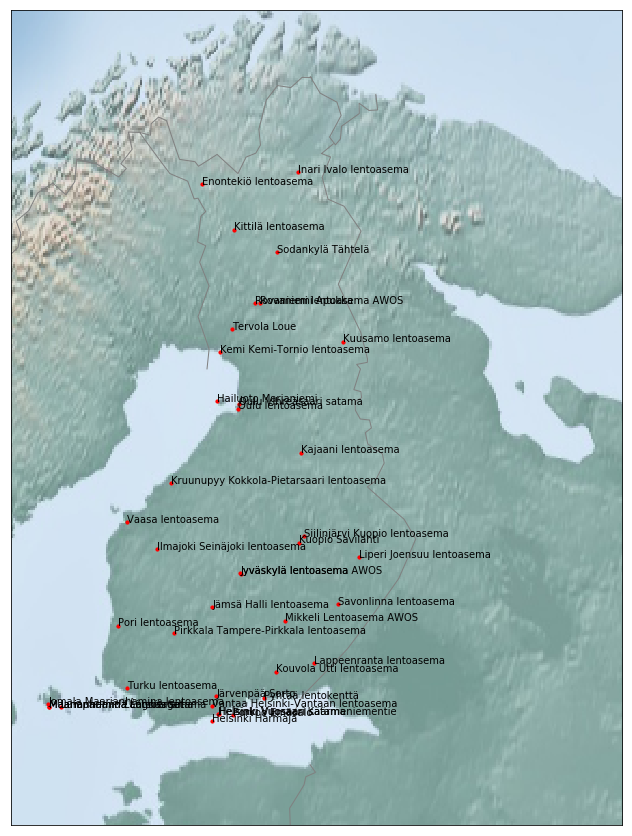

In [45]:
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),df_coords["longitude"].to_numpy().reshape(-1,1)))
#print(coords)

#figure = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(figsize=(20,15))

#fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='l', 
            lat_0=64.8238, lon_0=28.2179,
            width=1.05E6, height=1.4E6)
m.shadedrelief()
m.drawcountries(color='gray',linewidth=1)
m.drawstates(color='gray')
x, y = m(df_coords["longitude"].to_numpy(), df_coords["latitude"].to_numpy())  # transform coordinates
ax.scatter(x, y, 10, marker='o', color='Red')

for i, txt in enumerate(df_coords.index):
    ax.annotate(txt, (x[i], y[i]))

for edge_dmy in graph.edges:
    ax.plot([x[edge_dmy[0]],x[edge_dmy[1]]],[y[edge_dmy[0]],y[edge_dmy[1]]],'r--',lw=2)
    
plt.show